# First Five Notebooks for Thesis Work. Learn Code and Integrate them

# More Revised Unet + swin

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
import os
import glob
from tensorflow.keras import backend as K

K.clear_session()

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Global variable for VGG model
vgg = VGG19(include_top=False, input_shape=(128, 128, 3))
vgg.trainable = False
vgg_feat_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

# Perceptual Loss Function
def perceptual_loss(y_true, y_pred):
    true_features = vgg_feat_extractor(y_true)
    pred_features = vgg_feat_extractor(y_pred)
    return tf.reduce_mean(tf.square(true_features - pred_features))

# SSIM Loss
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Total Variation Loss (for sharpness)
def total_variation_loss(y_pred):
    return tf.image.total_variation(y_pred)

# Swin Transformer block implementation
class SwinTransformerBlock(layers.Layer):
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.1):
        super(SwinTransformerBlock, self).__init__()
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim, dropout=dropout)

        self.mlp = tf.keras.Sequential([
            layers.Dense(int(dim * mlp_ratio), activation='relu'),
            layers.Dense(dim)
        ])

    def call(self, x):
        h = self.norm1(x)
        attn_output = self.attn(h, h)
        x = x + attn_output
        h = self.norm2(x)
        x = x + self.mlp(h)
        return x

# Swin Transformer Layer
class SwinTransformerLayer(layers.Layer):
    def __init__(self, dim, depth, num_heads, mlp_ratio=4., dropout=0.1):
        super(SwinTransformerLayer, self).__init__()
        self.blocks = [SwinTransformerBlock(dim, num_heads, mlp_ratio, dropout) for _ in range(depth)]

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

# Swin Transformer Block (with variable depths)
def swin_transformer_block(input_tensor, num_heads, embed_dim, depth):
    height, width = input_tensor.shape[1], input_tensor.shape[2]  
    embed_layer = layers.Conv2D(embed_dim, kernel_size=4, strides=2, padding='same')(input_tensor)
    reshaped_layer = layers.Reshape((height // 2 * width // 2, embed_dim))(embed_layer)

    swin_layer = SwinTransformerLayer(embed_dim, depth, num_heads)
    transformed_layer = swin_layer(reshaped_layer)

    output_layer = layers.Reshape((height // 2, width // 2, embed_dim))(transformed_layer)
    return output_layer

# U-Net Encoder Block
def unet_encoder_block(input_tensor, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    return x

# U-Net Decoder Block
def unet_decoder_block(input_tensor, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    return x

# Hybrid U-Net + Swin Transformer Model
def unet_swin_transformer(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    enc1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    swin1 = swin_transformer_block(enc1, num_heads=4, embed_dim=64, depth=4)  # Swin1: 4 times
    pool1 = layers.Conv2D(128, (3, 3), strides=2, padding='same')(swin1)

    enc2 = unet_encoder_block(pool1, 128)
    swin2 = swin_transformer_block(enc2, num_heads=4, embed_dim=128, depth=2)  # Swin2: 2 times
    pool2 = layers.Conv2D(256, (3, 3), strides=2, padding='same')(swin2)

    enc3 = unet_encoder_block(pool2, 256)
    swin3 = swin_transformer_block(enc3, num_heads=4, embed_dim=256, depth=1)  # Swin3: 1 time
    pool3 = layers.Conv2D(512, (3, 3), strides=2, padding='same')(swin3)

    # Bottleneck
    bottleneck = unet_encoder_block(pool3, 512)

    # Decoder with Skip Connections
    dec3 = unet_decoder_block(bottleneck, 256)
    dec3 = layers.UpSampling2D(size=(2, 2))(dec3)  # Upsample to match swin3 (16x16)
    dec3 = layers.Concatenate()([dec3, swin3])

    dec2 = unet_decoder_block(dec3, 128)
    dec2 = layers.UpSampling2D(size=(2, 2))(dec2)  # Upsample to match swin2 (32x32)
    dec2 = layers.UpSampling2D(size=(2, 2))(dec2)
    dec2 = layers.Concatenate()([dec2, swin2])

    dec1 = unet_decoder_block(dec2, 64)
    dec1 = layers.UpSampling2D(size=(2, 2))(dec1)  # Upsample to match swin1 (64x64)
    dec1 = layers.UpSampling2D(size=(2, 2))(dec1)
    dec1 = layers.Concatenate()([dec1, swin1])
    
    print("Shape of dec1:", dec1.shape)
    
    outputs = layers.UpSampling2D(size=(2, 2))(dec1)  # Upsample from (64, 64) to (128, 128)
    outputs = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(outputs)  # Optional Conv2D for refinement

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(outputs)
    print("Shape of outputs:", outputs.shape)
    
    

    return Model(inputs, outputs)

# Load dataset (adjust the path to your dataset)
base_folder = '/kaggle/input/derainingdata/RainData'
(train_rainy, train_clear), (test_rainy, test_clear) = load_and_preprocess_datasets(base_folder, augment=True)

# Model compilation
model = unet_swin_transformer(input_shape=(128, 128, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=perceptual_loss,  # Adjusted loss function
              metrics=[ssim_loss])  # Additional metric

# Print the model summary
model.summary()

# Train the model with a smaller batch size
history = model.fit(train_rainy, train_clear, epochs=1, batch_size=1, validation_split=0.1)

# Evaluate model on test set
predictions = model.predict(test_rainy)

# Calculate PSNR and SSIM
def calculate_metrics(y_true, y_pred):
    psnr_values = []
    ssim_values = []
    for true, pred in zip(y_true, y_pred):
        psnr_values.append(psnr(true, pred, data_range=1))
        ssim_values.append(ssim(true, pred, multichannel=True))
    return np.mean(psnr_values), np.mean(ssim_values)

test_psnr, test_ssim = calculate_metrics(test_clear, predictions)

# Print the results
print(f'Test PSNR: {test_psnr:.2f} dB')
print(f'Test SSIM: {test_ssim:.4f}')

# Visualize some predictions
def visualize_predictions(rainy_images, clear_images, predicted_images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(rainy_images[i])
        plt.title('Rainy Image')
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(clear_images[i])
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(predicted_images[i])
        plt.title('Predicted Image')
        plt.axis('off')
    plt.show()

visualize_predictions(test_rainy, test_clear, predictions)


Shape of dec1: (None, 64, 64, 128)
Shape of outputs: (None, 128, 128, 3)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     65,600 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4096, 64)  │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_l… │ (None, 4096, 64)  │    398,848 │ reshape[0][0]     │
│ (SwinTransformerLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64,    │          0 │ swin_transformer… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ reshape_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    147,584 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    262,272 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 256, 128)  │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_l… │ (None, 256, 128)  │    792,064 │ reshape_2[0][0]   │
│ (SwinTransformerLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 16, 16,    │          0 │ swin_transformer… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,657,987 (55.92 MB)

 Trainable params: 14,657,987 (55.92 MB)

 Non-trainable params: 0 (0.00 B)

W0000 00:00:1727621604.633106    1048 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1727621604.634264    1048 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1727621604.635081    1048 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1727621604.635654    1048 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
I0000 00:00:1727621620.683065    1387 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_104', 256 bytes spill stores, 256 bytes spill loads

I0000 00:00:1727621624.171907    1386 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_153', 1016 bytes spill stores, 1016 bytes spill loads

I0000 00:00:1727621638.530409    1387 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_112', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:172

3240/3240 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 22.7779 - ssim_loss: 0.7547

W0000 00:00:1727622244.518076    1047 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1727622244.519281    1047 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1727622244.520157    1047 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1727622244.520768    1047 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert


3240/3240 ━━━━━━━━━━━━━━━━━━━━ 684s 182ms/step - loss: 22.7777 - ssim_loss: 0.7547 - val_loss: 21.6745 - val_ssim_loss: 0.7473


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_1004/3557820434.py", line 225, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

Out of memory while trying to allocate 8606711808 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_241569]



# Revised Unet + swin 

After embedding: (None, 64, 64, 64)
Output of Swin block: (None, 64, 64, 64)
After first pooling: (None, 32, 32, 128)
After encoder block with 128 filters: (None, 32, 32, 128)
After embedding: (None, 16, 16, 128)
Output of Swin block: (None, 16, 16, 128)
After second pooling: (None, 8, 8, 256)
After encoder block with 256 filters: (None, 8, 8, 256)
After embedding: (None, 4, 4, 256)
Output of Swin block: (None, 4, 4, 256)
After third pooling: (None, 2, 2, 512)
After encoder block with 512 filters: (None, 2, 2, 512)
After bottleneck: (None, 2, 2, 512)
After decoder block with 256 filters: (None, 2, 2, 256)
After upsampling dec3 to match swin3: (None, 4, 4, 256)
After concatenation with skip connection from swin3: (None, 4, 4, 512)
After decoder block with 128 filters: (None, 4, 4, 128)
After upsampling dec2 to match swin2: (None, 8, 8, 128)
After downsampling swin2: (None, 8, 8, 128)
After concatenation with skip connection from swin2: (None, 8, 8, 256)
After decoder block with 64 filte

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_42[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 64, 64,    │     65,600 │ conv2d_132[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_36          │ (None, 4096, 64)  │          0 │ conv2d_133[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_l… │ (None, 4096, 64)  │    199,424 │ reshape_36[0][0]  │
│ (SwinTransformerLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_37          │ (None, 64, 64,    │          0 │ swin_transformer… │
│ (Reshape)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 32, 32,    │     73,856 │ reshape_37[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 32, 32,    │    147,584 │ conv2d_134[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_72 (ReLU)     │ (None, 32, 32,    │          0 │ conv2d_135[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 32, 32,    │    147,584 │ re_lu_72[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_73 (ReLU)     │ (None, 32, 32,    │          0 │ conv2d_136[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 16, 16,    │    262,272 │ re_lu_73[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_38          │ (None, 256, 128)  │          0 │ conv2d_137[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ swin_transformer_l… │ (None, 256, 128)  │    792,064 │ reshape_38[0][0]  │
│ (SwinTransformerLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_39          │ (None, 16, 16,    │          0 │ swin_transformer… │
│ (Reshape)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 8, 8, 256) │    295,168 │ reshape_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 8, 8, 256) │    590,080 │ conv2d_138[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,410,115 (62.60 MB)

 Trainable params: 16,410,115 (62.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 267s 294ms/step - loss: 0.0463 - mae: 0.1704 - val_loss: 0.0399 - val_mae: 0.1584
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 232s 286ms/step - loss: 0.0397 - mae: 0.1555 - val_loss: 0.0406 - val_mae: 0.1606
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 232s 286ms/step - loss: 0.0376 - mae: 0.1499 - val_loss: 0.0346 - val_mae: 0.1420
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 232s 286ms/step - loss: 0.0342 - mae: 0.1411 - val_loss: 0.0346 - val_mae: 0.1409
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 232s 287ms/step - loss: 0.0329 - mae: 0.1377 - val_loss: 0.0348 - val_mae: 0.1448
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 232s 287ms/step - loss: 0.0332 - mae: 0.1383 - val_loss: 0.0336 - val_mae: 0.1391
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 232s 287ms/step - loss: 0.0315 - mae: 0.1339 - val_loss: 0.0335 - val_mae: 0.1407
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 232s 287ms/step - loss: 0.0316 - mae: 0.1342 - val_loss: 0.0333 - val_mae: 0.1376
Epoch 9/20
810/810 ━━━━━

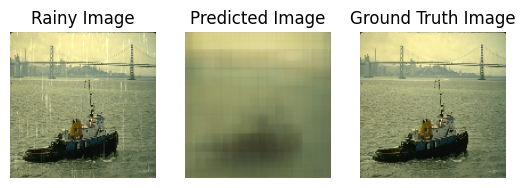

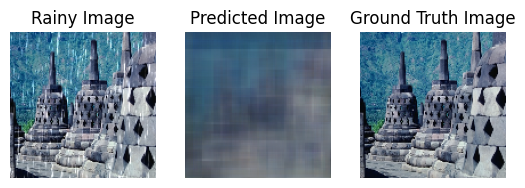

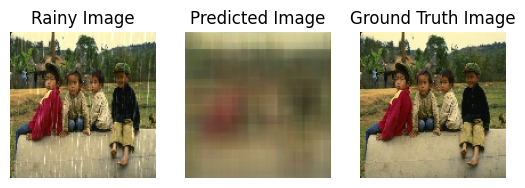

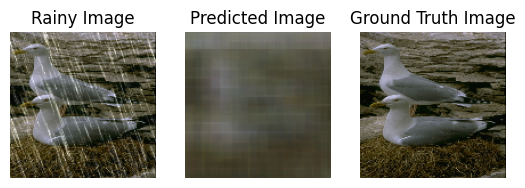

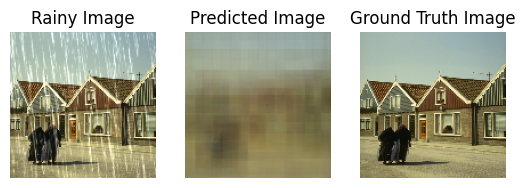

Mean PSNR: 16.097649799161392, Mean SSIM: 0.5721240593938443


'# Evaluation\npredictions = model.predict(test_rainy)\n\n# Display predictions\nfor i in range(min(5, predictions.shape[0])):\n    plt.subplot(1, 3, 1)\n    plt.imshow(test_rainy[i])\n    plt.title(\'Rainy Image\')\n    plt.axis(\'off\')\n\n    plt.subplot(1, 3, 2)\n    plt.imshow(predictions[i])\n    plt.title(\'Predicted Image\')\n    plt.axis(\'off\')\n\n    plt.subplot(1, 3, 3)\n    plt.imshow(test_clear[i])\n    plt.title(\'Ground Truth Image\')\n    plt.axis(\'off\')\n\n    plt.show()\n\n# Calculate PSNR and SSIM\ndef calculate_metrics(predictions, ground_truth):\n    psnr_values = []\n    ssim_values = []\n    for i in range(predictions.shape[0]):\n        psnr_val = psnr(ground_truth[i], predictions[i])\n        ssim_val = ssim(ground_truth[i], predictions[i], multichannel=True)\n        psnr_values.append(psnr_val)\n        ssim_values.append(ssim_val)\n    return np.mean(psnr_values), np.mean(ssim_values)\n\nmean_psnr, mean_ssim = calculate_metrics(predictions, test_clear)\n

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import glob
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)  # Convert image to float in [0, 1]
        img_resized = tf.image.resize(img, size).numpy()
        # Remove normalization if img_as_float is already in [0, 1]
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Swin Transformer block implementation
class SwinTransformerBlock(layers.Layer):
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.0):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.num_heads = num_heads

        # Layer normalization
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        # Multi-head self-attention layer
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim, dropout=dropout)

        # MLP layer
        self.mlp = tf.keras.Sequential([
            layers.Dense(int(dim * mlp_ratio), activation='relu'),
            layers.Dense(dim)
        ])

    def call(self, x):
        h = self.norm1(x)  # Apply normalization for attention
        attn_output = self.attn(h, h)  # Self-attention

        # Residual connection
        x = x + attn_output

        h = self.norm2(x)  # Apply normalization for MLP
        x = x + self.mlp(h)  # Residual connection for MLP
        return x

# Window-based Swin Transformer Layer (basic building block)
class SwinTransformerLayer(layers.Layer):
    def __init__(self, dim, depth, num_heads, mlp_ratio=4., dropout=0.0):
        super(SwinTransformerLayer, self).__init__()
        self.blocks = [SwinTransformerBlock(dim, num_heads, mlp_ratio, dropout) for _ in range(depth)]

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

# Window-based Swin Transformer block applied after each downsampling
def swin_transformer_block(input_tensor, num_heads, embed_dim, depths):
    height, width = input_tensor.shape[1], input_tensor.shape[2]  # Keras tensor shape
    embed_layer = layers.Conv2D(embed_dim, kernel_size=4, strides=2, padding='same')(input_tensor)  # Reduce spatial size
    print(f"After embedding: {embed_layer.shape}")  # Print dimension after embedding

    # Reshape for Swin Transformer: Batch, Height * Width, Channels
    reshaped_layer = layers.Reshape((height // 2 * width // 2, embed_dim))(embed_layer)

    # Apply Swin Transformer layers (recursive depth)
    swin_layer = SwinTransformerLayer(embed_dim, depths[0], num_heads)
    transformed_layer = swin_layer(reshaped_layer)

    # Reshape back to original spatial dimensions
    output_layer = layers.Reshape((height // 2, width // 2, embed_dim))(transformed_layer)
    print(f"Output of Swin block: {output_layer.shape}")  # Print dimension after Swin Transformer block

    return output_layer

# U-Net Encoder Block
def unet_encoder_block(input_tensor, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    print(f"After encoder block with {filters} filters: {x.shape}")  # Print dimension after encoder block
    return x

# U-Net Decoder Block
def unet_decoder_block(input_tensor, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.ReLU()(x)
    print(f"After decoder block with {filters} filters: {x.shape}")  # Print dimension after decoder block
    return x

# Hybrid U-Net + Swin Transformer Model
def unet_swin_transformer(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder (with multi-scale feature extraction)
    enc1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    swin1 = swin_transformer_block(enc1, num_heads=4, embed_dim=64, depths=[2])
    pool1 = layers.Conv2D(128, (3, 3), strides=2, padding='same')(swin1)
    print(f"After first pooling: {pool1.shape}")  # Print dimension after first pooling

    enc2 = unet_encoder_block(pool1, 128)
    swin2 = swin_transformer_block(enc2, num_heads=4, embed_dim=128, depths=[2])
    pool2 = layers.Conv2D(256, (3, 3), strides=2, padding='same')(swin2)
    print(f"After second pooling: {pool2.shape}")  # Print dimension after second pooling

    enc3 = unet_encoder_block(pool2, 256)
    swin3 = swin_transformer_block(enc3, num_heads=4, embed_dim=256, depths=[2])
    pool3 = layers.Conv2D(512, (3, 3), strides=2, padding='same')(swin3)
    print(f"After third pooling: {pool3.shape}")  # Print dimension after third pooling

    # Bottleneck
    bottleneck = unet_encoder_block(pool3, 512)
    print(f"After bottleneck: {bottleneck.shape}")  # Print dimension after bottleneck

    # Decoder
    dec3 = unet_decoder_block(bottleneck, 256)
    dec3 = layers.UpSampling2D(size=(2, 2))(dec3)  # Upsample to match swin3
    print(f"After upsampling dec3 to match swin3: {dec3.shape}")  # Print upsampled dimension
    dec3 = layers.Concatenate()([dec3, swin3])  # Concatenate with skip connection from swin3
    print(f"After concatenation with skip connection from swin3: {dec3.shape}")  # Print dimension after concatenation

    dec2 = unet_decoder_block(dec3, 128)
    dec2 = layers.UpSampling2D(size=(2, 2))(dec2)  # Upsample to match swin2
    print(f"After upsampling dec2 to match swin2: {dec2.shape}")  # Print upsampled dimension

    # Downsample swin2 to match dec2's shape
    swin2_downsampled = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(swin2)
    print(f"After downsampling swin2: {swin2_downsampled.shape}")  # Print downsampled swin2 shape
    dec2 = layers.Concatenate()([dec2, swin2_downsampled])  # Concatenate with skip connection from downsampled swin2
    print(f"After concatenation with skip connection from swin2: {dec2.shape}")  # Print dimension after concatenation

    dec1 = unet_decoder_block(dec2, 64)
    dec1 = layers.UpSampling2D(size=(2, 2))(dec1)  # Upsample to match swin1
    print(f"After upsampling dec1 to match swin1: {dec1.shape}")  # Print upsampled dimension

    # Upsample swin1 to match dec1's shape
    swin1_downsampled = layers.Conv2D(64, kernel_size=3, strides=(4, 4), padding='same')(swin1)
    #swin1_upsampled = layers.UpSampling2D(size=(2, 2))(swin1_upsampled)  # Ensure the dimensions match after upsampling
    print(f"After upsampling swin1: {swin1_downsampled.shape}")  # Print upsampled swin1 shape
    dec1 = layers.Concatenate()([dec1, swin1_downsampled])  # Concatenate with skip connection from upsampled swin1
    print(f"After concatenation with skip connection from swin1: {dec1.shape}")  # Print dimension after concatenation
    
    upsampled = layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same')(dec1)
    upsampled = layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same')(upsampled)
    upsampled = layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same')(upsampled)


    # Output layer (assuming 3-channel RGB output)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(upsampled)
    print(f"Output layer shape: {outputs.shape}")  # Print output shape

    return Model(inputs, outputs)


# Load dataset
base_folder = '/kaggle/input/derainingdata/RainData'  # Replace with your dataset path
(train_rainy, train_clear), (test_rainy, test_clear) = load_and_preprocess_datasets(base_folder, augment=True)

# Instantiate and compile model
input_shape = (128, 128, 3)  # Assuming input images are RGB
model = unet_swin_transformer(input_shape)
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Model summary
model.summary()

# Training
history = model.fit(train_rainy, train_clear, validation_split=0.1, epochs=20, batch_size=4)

# Calculate PSNR and SSIM
def calculate_metrics(predictions, ground_truth):
    psnr_values = []
    ssim_values = []
    
    # Define a smaller window size if images are less than 7x7
    win_size = 3  # Use a smaller window size if necessary
    
    # Determine the data range
    data_range = 1.0  # Assuming images are normalized between [0, 1]
    
    for i in range(predictions.shape[0]):
        psnr_val = psnr(ground_truth[i], predictions[i])
        
        # Ensure the window size is appropriate for the image dimensions
        if ground_truth[i].shape[0] < 7 or ground_truth[i].shape[1] < 7:
            ssim_val = ssim(ground_truth[i], predictions[i], multichannel=True, win_size=3, data_range=data_range)
        else:
            ssim_val = ssim(ground_truth[i], predictions[i], multichannel=True, win_size=win_size, data_range=data_range)
        
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)
    
    return np.mean(psnr_values), np.mean(ssim_values)

# Evaluation
try:
    predictions = model.predict(test_rainy, batch_size=1)  # Use smaller batch size to avoid memory issues

    # Display predictions
    for i in range(min(5, predictions.shape[0])):
        plt.subplot(1, 3, 1)
        plt.imshow(test_rainy[i])
        plt.title('Rainy Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(predictions[i])
        plt.title('Predicted Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(test_clear[i])
        plt.title('Ground Truth Image')
        plt.axis('off')

        plt.show()

    # Calculate PSNR and SSIM
    mean_psnr, mean_ssim = calculate_metrics(predictions, test_clear)
    print(f"Mean PSNR: {mean_psnr}, Mean SSIM: {mean_ssim}")

except Exception as e:
    print("Error during evaluation:", e)



'''# Evaluation
predictions = model.predict(test_rainy)

# Display predictions
for i in range(min(5, predictions.shape[0])):
    plt.subplot(1, 3, 1)
    plt.imshow(test_rainy[i])
    plt.title('Rainy Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predictions[i])
    plt.title('Predicted Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(test_clear[i])
    plt.title('Ground Truth Image')
    plt.axis('off')

    plt.show()

# Calculate PSNR and SSIM
def calculate_metrics(predictions, ground_truth):
    psnr_values = []
    ssim_values = []
    for i in range(predictions.shape[0]):
        psnr_val = psnr(ground_truth[i], predictions[i])
        ssim_val = ssim(ground_truth[i], predictions[i], multichannel=True)
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)
    return np.mean(psnr_values), np.mean(ssim_values)

mean_psnr, mean_ssim = calculate_metrics(predictions, test_clear)
print(f"Mean PSNR: {mean_psnr}, Mean SSIM: {mean_ssim}")'''




# UNet + swin

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import glob
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Swin Transformer block implementation
class SwinTransformerBlock(layers.Layer):
    def __init__(self, dim, num_heads, mlp_ratio=4., dropout=0.0):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.num_heads = num_heads

        # Layer normalization
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        # Multi-head self-attention layer
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim, dropout=dropout)

        # MLP layer
        self.mlp = tf.keras.Sequential([
            layers.Dense(int(dim * mlp_ratio), activation='relu'),
            layers.Dense(dim)
        ])

    def call(self, x):
        h = self.norm1(x)  # Apply normalization for attention
        attn_output = self.attn(h, h)  # Self-attention

        # Residual connection
        x = x + attn_output

        h = self.norm2(x)  # Apply normalization for MLP
        x = x + self.mlp(h)  # Residual connection for MLP
        return x

# Window-based Swin Transformer Layer (basic building block)
class SwinTransformerLayer(layers.Layer):
    def __init__(self, dim, depth, num_heads, mlp_ratio=4., dropout=0.0):
        super(SwinTransformerLayer, self).__init__()
        self.blocks = [SwinTransformerBlock(dim, num_heads, mlp_ratio, dropout) for _ in range(depth)]

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x

# Swin transformer block applied after each downsampling
def swin_transformer_block(input_tensor, num_heads, embed_dim, depths):
    # Patch partition (flatten input image into non-overlapping patches)
    height, width = input_tensor.shape[1], input_tensor.shape[2]  # Keras tensor shape
    embed_layer = layers.Conv2D(embed_dim, kernel_size=4, strides=2, padding='same')(input_tensor)  # Reduce spatial size

    # Reshape for Swin Transformer: Batch, Height * Width, Channels
    reshaped_layer = layers.Reshape((height // 2 * width // 2, embed_dim))(embed_layer)

    # Apply Swin Transformer layers (recursive depth)
    swin_layer = SwinTransformerLayer(embed_dim, depths[0], num_heads)
    transformed_layer = swin_layer(reshaped_layer)

    # Reshape back to original spatial dimensions
    output_layer = layers.Reshape((height // 2, width // 2, embed_dim))(transformed_layer)

    return output_layer

# U-Net Encoder Block (with Strided Convolutions for downsampling)
def unet_encoder_block(input_tensor, filters, kernel_size=3, padding='same', strides=1):
    x = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# U-Net Decoder Block
def unet_decoder_block(input_tensor, skip_tensor, filters, kernel_size=3, padding='same', strides=1):
    x = layers.Conv2DTranspose(filters, kernel_size, padding=padding, strides=2)(input_tensor)
    # Ensure dimensions are correct before concatenation
    if skip_tensor.shape[1] != x.shape[1] or skip_tensor.shape[2] != x.shape[2]:
        x = layers.Resizing(skip_tensor.shape[1], skip_tensor.shape[2])(x)  # Resize if needed
    print(f"Decoding: {x.shape}, Skip: {skip_tensor.shape}")
    x = layers.Concatenate()([x, skip_tensor])
    x = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Hybrid U-Net + Swin Transformer Model
def unet_swin_transformer(input_shape):
    inputs = layers.Input(shape=input_shape)

    # U-Net Encoder with Strided Convolutions and Swin Transformer at each downsampling step
    enc1 = unet_encoder_block(inputs, 64)
    swin1 = swin_transformer_block(enc1, num_heads=4, embed_dim=64, depths=[2])
    pool1 = layers.Conv2D(128, (3, 3), strides=2, padding='same')(swin1)  # Strided convolution for downsampling

    enc2 = unet_encoder_block(pool1, 128)
    swin2 = swin_transformer_block(enc2, num_heads=4, embed_dim=128, depths=[2])
    pool2 = layers.Conv2D(256, (3, 3), strides=2, padding='same')(swin2)  # Strided convolution for downsampling

    enc3 = unet_encoder_block(pool2, 256)
    swin3 = swin_transformer_block(enc3, num_heads=4, embed_dim=256, depths=[2])
    pool3 = layers.Conv2D(512, (3, 3), strides=2, padding='same')(swin3)  # Strided convolution for downsampling

    enc4 = unet_encoder_block(pool3, 512)
    swin4 = swin_transformer_block(enc4, num_heads=4, embed_dim=512, depths=[2])

    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), strides=2, padding='same')(swin4)

    # Decoder with Skip Connections
    dec4 = unet_decoder_block(bottleneck, enc4, 512)
    dec3 = unet_decoder_block(dec4, enc3, 256)
    dec2 = unet_decoder_block(dec3, enc2, 128)
    dec1 = unet_decoder_block(dec2, enc1, 64)

    # Final output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(dec1)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
input_shape = (128, 128, 3)  # Input image dimensions
model = unet_swin_transformer(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# Print model summary
model.summary()
# Function to calculate PSNR and SSIM
def calculate_metrics(original, generated):
    psnr_value = psnr(original, generated)
    ssim_value = ssim(original, generated, multichannel=True)
    return psnr_value, ssim_value

# Training function
def train_model(model, train_data, epochs=100, batch_size=16):
    rainy_images, clear_images = train_data
    model.fit(rainy_images, clear_images, epochs=epochs, batch_size=batch_size)

# Evaluation function on the test set
def evaluate_model(model, test_data):
    rainy_images_test, clear_images_test = test_data
    predictions = model.predict(rainy_images_test)

    # Calculate metrics for each image
    psnr_values = []
    ssim_values = []
    for i in range(len(predictions)):
        psnr_value, ssim_value = calculate_metrics(clear_images_test[i], predictions[i])
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
base_folder = '/kaggle/input/derainingdata/RainData'
(train_data, test_data) = load_and_preprocess_datasets(base_folder, augment=True)
train_model(model, train_data, epochs=10, batch_size=16)
avg_psnr, avg_ssim = evaluate_model(model, test_data)

print(f'Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}')

# Display predicted images (for the first 5 test images)
predictions = model.predict(test_data[0])
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(test_data[0][i])  # Display rainy image
    plt.axis('off')
    plt.subplot(3, 5, i + 6)
    plt.imshow(predictions[i])  # Display predicted clear image
    plt.axis('off')
    plt.subplot(3, 5, i + 11)
    plt.imshow(test_data[1][i])  # Display ground truth image
    plt.axis('off')
plt.show()

# Image Preprocessing

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []  # Corrected initialization

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Example usage
base_folder = '/kaggle/input/derainingdata/RainData'
(train_rainy, train_clear), (test_rainy, test_clear) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

print(f"Training Rainy Images Shape: {train_rainy.shape}")
print(f"Training Clear Images Shape: {train_clear.shape}")
print(f"Testing Rainy Images Shape: {test_rainy.shape}")
print(f"Testing Clear Images Shape: {test_clear.shape}")


# Pyramid Model

In [ ]:
# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        
        # Resizing each input for different scales
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        
        # Dynamic kernel size based on scale
        kernel_size = 3 + scale
        
        # Use Depthwise Separable Convolutions
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)  # Pointwise Conv
        
        # Residual connection
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        
        # Resize back to original input size before concatenation
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        pyramid_features.append(x_resized)

    # Concatenate all pyramid features along channel axis
    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    return inputs, fused_features

# Swin transformer for image Restoration

In [ ]:
# -----------------------------------------------------------------------------------
# SwinIR: Image Restoration Using Swin Transformer, https://arxiv.org/abs/2108.10257
# Originally Written by Ze Liu, Modified by Jingyun Liang.
# -----------------------------------------------------------------------------------

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)
        
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops


if __name__ == '__main__':
    upscale = 4
    window_size = 8
    height = (1024 // upscale // window_size + 1) * window_size
    width = (720 // upscale // window_size + 1) * window_size
    model = SwinIR(upscale=2, img_size=(height, width),
                   window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                   embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')
    print(model)
    print(height, width, model.flops() / 1e9)

    x = torch.randn((1, 3, height, width))
    x = model(x)
    print(x.shape)

# Image Restoration and Enhancement

In [ ]:
# Image Restoration and Enhancement Block
def image_restoration_and_enhancement(inputs, num_classes=3):
    # Normalize the input features
    x = LayerNormalization()(inputs)
    
    # Using Depthwise Separable Convolutions
    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(x)
    
    return x

# Compile Model 

In [ ]:
# Full Model Creation
def build_full_model(input_shape):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Dynamic Pyramid Model
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)

    # Image Restoration and Enhancement
    outputs = image_restoration_and_enhancement(pyramid_features, num_classes=input_shape[-1])

    return Model(inputs=inputs, outputs=outputs)

# Load dataset
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

# Show some example images to verify data loading
plt.imshow(rainy_train[0])
plt.title("Sample Rainy Image")
plt.show()

plt.imshow(clear_train[0])
plt.title("Sample Clear Image")
plt.show()

# Build the model
input_shape = rainy_train[0].shape  # Assuming your input images are all the same size
model = build_full_model(input_shape)
model.summary()

# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Proper TensorFlow logging
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

# Custom callback to print CPU/GPU usage
class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Print resource information at the beginning of each epoch
        print(f"Epoch {epoch + 1} starting...")
        
        # Check CPU utilization
        cpu_info = os.popen("lscpu").read()
        print(f"CPU Info:\n{cpu_info}")
        
        # Check GPU utilization if available
        if tf.config.list_physical_devices('GPU'):
            gpu_info = os.popen("nvidia-smi").read()
            print(f"GPU Info:\n{gpu_info}")
        else:
            print("No GPU detected, using CPU.")
        
    def on_epoch_end(self, epoch, logs=None):
        # Summary of the epoch
        print(f"Epoch {epoch + 1} ended. Loss: {logs.get('loss')}, Validation Loss: {logs.get('val_loss')}")
        print("=" * 50)

# Ensure the dataset isn't infinite
batch_size = 4
steps_per_epoch = len(rainy_train) // batch_size  # Ensure steps per epoch is finite

# Add debug prints in your data preprocessing and training loops
print(f"Dataset Size: {len(rainy_train)}")
print(f"Steps per Epoch: {steps_per_epoch}")

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    rainy_train, clear_train,
    validation_data=(rainy_test, clear_test),
    epochs=50,
    batch_size=8,  # Change this value if necessary
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Evaluate the model
predicted_images = model.predict(rainy_test)

# Calculate MSE
mse = mean_squared_error(clear_test.flatten(), predicted_images.flatten())
print("Mean Squared Error on Test Set: ", mse)

# Calculate PSNR
psnr_value = tf.reduce_mean(psnr(clear_test, predicted_images, max_val=1.0))
print("PSNR on Test Set: ", psnr_value.numpy())

# Calculate SSIM (with win_size <= 7, and using channel_axis instead of multichannel)
ssim_values = []
for i in range(len(clear_test)):
    ssim_value = ssim(clear_test[i], predicted_images[i], win_size=5, channel_axis=-1)  # Set win_size <= 7
    ssim_values.append(ssim_value)

avg_ssim_value = np.mean(ssim_values)
print("Average SSIM on Test Set: ", avg_ssim_value)

# New concept

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Optionally, force CPU for debugging
# tf.config.set_visible_devices([], 'GPU')

# Disable XLA to avoid issues
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        
        # Resizing each input for different scales
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        
        # Dynamic kernel size based on scale
        kernel_size = 3 + scale
        
        # Use Depthwise Separable Convolutions
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)  # Pointwise Conv
        
        # Residual connection
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        
        # Resize back to original input size before concatenation
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        pyramid_features.append(x_resized)

    # Concatenate all pyramid features along channel axis
    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    return inputs, fused_features

# Swin Transformer Block Implementation with k-th Attention
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=4, shift_size=0, mlp_ratio=4.):
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k  # Number of top-k attention weights
        self.dim = dim
        
        # Layer normalization
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        
        # Multi-head self-attention
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        
        # Feed-forward network
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])
    
    def call(self, x):
        # Layer normalization
        x_norm = self.norm1(x)

        # Compute attention
        attn_output = self.attn(x_norm, x_norm)

        # Get top-k attention weights
        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))  # Computing attention weights
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)

        # Suppress weights below the threshold
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)

        # Normalize the weights again after thresholding
        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)

        # Use the modified attention weights to compute output
        attn_output = tf.matmul(attn_weights, attn_output)

        # Skip connection
        x = x + attn_output  

        # Feed-forward network
        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  # Skip connection
        
        return x

def swin_transformer_block(inputs):
    # Define parameters for the Swin Transformer Block
    dim = inputs.shape[-1]  # Input channel dimension
    num_heads = 4  # Number of attention heads
    window_size = 7  # Size of the window
    shift_size = 0  # Shift size for the windowing scheme
    
    # Create the Swin Transformer Block
    x = SwinTransformerBlock(dim, num_heads, window_size, k=4, shift_size=shift_size)(inputs)
    
    return x

# Recursive Swin Transformer Block with residual connections
def recursive_swin_transformer_block(inputs, num_recursions=6):
    x = inputs
    for _ in range(num_recursions):
        # Call the Swin Transformer block
        x = swin_transformer_block(x)
    
    return x

# Image Restoration and Enhancement Block
def image_restoration_and_enhancement(inputs, num_classes=3):
    # Normalize the input features
    x = LayerNormalization()(inputs)
    
    # Using Depthwise Separable Convolutions
    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(x)
    
    return x

# Full Model Creation
def build_full_model(input_shape):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Dynamic Pyramid Model
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)

    # Recursive Swin Transformer Block
    transformer_features = recursive_swin_transformer_block(pyramid_features)

    # Image Restoration and Enhancement
    outputs = image_restoration_and_enhancement(transformer_features, num_classes=input_shape[-1])

    return Model(inputs=inputs, outputs=outputs)

# Load dataset
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

# Show some example images to verify data loading
plt.imshow(rainy_train[0])
plt.title("Sample Rainy Image")
plt.show()

plt.imshow(clear_train[0])
plt.title("Sample Clear Image")
plt.show()

# Build the model
input_shape = rainy_train[0].shape  # Assuming your input images are all the same size
model = build_full_model(input_shape)
model.summary()

# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Proper TensorFlow logging
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

# Custom callback to print CPU/GPU usage
class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Print resource information at the beginning of each epoch
        print(f"Epoch {epoch + 1} starting...")
        
        # Check CPU utilization
        cpu_info = os.popen("lscpu").read()
        print(f"CPU Info:\n{cpu_info}")
        
        # Check GPU utilization if available
        if tf.config.list_physical_devices('GPU'):
            gpu_info = os.popen("nvidia-smi").read()
            print(f"GPU Info:\n{gpu_info}")
        else:
            print("No GPU detected, using CPU.")
        
    def on_epoch_end(self, epoch, logs=None):
        # Summary of the epoch
        print(f"Epoch {epoch + 1} ended. Loss: {logs.get('loss')}, Validation Loss: {logs.get('val_loss')}")
        print("=" * 50)

# Ensure the dataset isn't infinite
batch_size = 4
steps_per_epoch = len(rainy_train) // batch_size  # Ensure steps per epoch is finite

# Add debug prints in your data preprocessing and training loops
print(f"Dataset Size: {len(rainy_train)}")
print(f"Steps per Epoch: {steps_per_epoch}")

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    rainy_train, clear_train,
    validation_data=(rainy_test, clear_test),
    epochs=50,
    batch_size=8,  # Change this value if necessary
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Evaluate the model
mse = mean_squared_error(clear_test.flatten(), model.predict(rainy_test).flatten())
print("Mean Squared Error on Test Set: ", mse)

# You can also calculate SSIM
ssim_value = ssim(clear_test[0], model.predict(rainy_test)[0], multichannel=True)
print("SSIM Value on Test Set: ", ssim_value)


# Without Swin

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, DepthwiseConv2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from tensorflow.image import psnr  # Importing TensorFlow's PSNR function

# Optionally, force CPU for debugging
# tf.config.set_visible_devices([], 'GPU')

# Disable XLA to avoid issues
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        
        # Resizing each input for different scales
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        
        # Dynamic kernel size based on scale
        kernel_size = 3 + scale
        
        # Use Depthwise Separable Convolutions
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)  # Pointwise Conv
        
        # Residual connection
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        
        # Resize back to original input size before concatenation
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        pyramid_features.append(x_resized)

    # Concatenate all pyramid features along channel axis
    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    return inputs, fused_features

# Image Restoration and Enhancement Block
def image_restoration_and_enhancement(inputs, num_classes=3):
    # Normalize the input features
    x = LayerNormalization()(inputs)
    
    # Using Depthwise Separable Convolutions
    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)  # Pointwise Conv

    x = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(x)
    
    return x

# Full Model Creation
def build_full_model(input_shape):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Dynamic Pyramid Model
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)

    # Image Restoration and Enhancement
    outputs = image_restoration_and_enhancement(pyramid_features, num_classes=input_shape[-1])

    return Model(inputs=inputs, outputs=outputs)

# Load dataset
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

# Show some example images to verify data loading
plt.imshow(rainy_train[0])
plt.title("Sample Rainy Image")
plt.show()

plt.imshow(clear_train[0])
plt.title("Sample Clear Image")
plt.show()

# Build the model
input_shape = rainy_train[0].shape  # Assuming your input images are all the same size
model = build_full_model(input_shape)
model.summary()

# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Proper TensorFlow logging
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

# Custom callback to print CPU/GPU usage
class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Print resource information at the beginning of each epoch
        print(f"Epoch {epoch + 1} starting...")
        
        # Check CPU utilization
        cpu_info = os.popen("lscpu").read()
        print(f"CPU Info:\n{cpu_info}")
        
        # Check GPU utilization if available
        if tf.config.list_physical_devices('GPU'):
            gpu_info = os.popen("nvidia-smi").read()
            print(f"GPU Info:\n{gpu_info}")
        else:
            print("No GPU detected, using CPU.")
        
    def on_epoch_end(self, epoch, logs=None):
        # Summary of the epoch
        print(f"Epoch {epoch + 1} ended. Loss: {logs.get('loss')}, Validation Loss: {logs.get('val_loss')}")
        print("=" * 50)

# Ensure the dataset isn't infinite
batch_size = 4
steps_per_epoch = len(rainy_train) // batch_size  # Ensure steps per epoch is finite

# Add debug prints in your data preprocessing and training loops
print(f"Dataset Size: {len(rainy_train)}")
print(f"Steps per Epoch: {steps_per_epoch}")

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    rainy_train, clear_train,
    validation_data=(rainy_test, clear_test),
    epochs=50,
    batch_size=8,  # Change this value if necessary
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Evaluate the model
predicted_images = model.predict(rainy_test)

# Calculate MSE
mse = mean_squared_error(clear_test.flatten(), predicted_images.flatten())
print("Mean Squared Error on Test Set: ", mse)

# Calculate PSNR
psnr_value = tf.reduce_mean(psnr(clear_test, predicted_images, max_val=1.0))
print("PSNR on Test Set: ", psnr_value.numpy())

# Calculate SSIM (with win_size <= 7, and using channel_axis instead of multichannel)
ssim_values = []
for i in range(len(clear_test)):
    ssim_value = ssim(clear_test[i], predicted_images[i], win_size=5, channel_axis=-1)  # Set win_size <= 7
    ssim_values.append(ssim_value)

avg_ssim_value = np.mean(ssim_values)
print("Average SSIM on Test Set: ", avg_ssim_value)


# Pruned model

In [ ]:
!pip install tensorflow-model-optimization

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_model_optimization as tfmot
from tensorflow.keras.losses import KLDivergence

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    """
    Loads and resizes images from a specified folder.

    Args:
        folder (str): Path to the folder containing images.
        size (tuple): Desired size for resizing the images (width, height).

    Returns:
        np.array: Array of loaded and resized images.
    """
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    """
    Preprocess and augment image data.

    Args:
        images (np.array): Array of images to preprocess.
        augment (bool): If True, applies augmentation to the images.

    Returns:
        np.array: Preprocessed (and possibly augmented) images.
    """
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    """
    Loads and preprocesses the dataset for training and testing.

    Args:
        base_folder (str): Path to the base folder containing datasets.
        size (tuple): Desired size for resizing the images.
        augment (bool): If True, applies data augmentation to training data.

    Returns:
        tuple: Training and testing datasets for rainy and clear images.
    """
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    """
    Builds an advanced dynamic pyramid model.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_scales (int): Number of scales for the pyramid model.

    Returns:
        tuple: Model input and concatenated pyramid features.
    """
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        kernel_size = 3 + scale
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        pyramid_features.append(x_resized)

    fused_features = Lambda(lambda x: tf.concat(x, axis=-1))(pyramid_features)
    return inputs, fused_features

# Swin Transformer Block
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=4, shift_size=0, mlp_ratio=4.):
        """
        Swin Transformer Block with top-k sparsity applied.

        Args:
            dim (int): Input dimension size.
            num_heads (int): Number of attention heads.
            window_size (int): Size of the local attention window.
            k (int): Top-k sparsity parameter.
            shift_size (int): Shift size for shifted windowing.
            mlp_ratio (float): Ratio for the MLP hidden size.
        """
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k
        self.dim = dim
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])

    def call(self, x):
        """
        Applies Swin transformer block with top-k sparsity attention.

        Args:
            x: Input tensor.

        Returns:
            Tensor after applying attention and MLP.
        """
        x_norm = self.norm1(x)
        attn_output = self.attn(x_norm, x_norm)
        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)
        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)
        attn_output = tf.matmul(attn_weights, attn_output)
        x = x + attn_output  
        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  
        return x

# Swin Transformer block helper functions
def swin_transformer_block(inputs):
    dim = inputs.shape[-1]
    num_heads = 4
    window_size = 7
    x = SwinTransformerBlock(dim, num_heads, window_size, k=4)(inputs)
    return x

def recursive_swin_transformer_block(inputs, num_recursions=6):
    """
    Builds a recursive Swin transformer block for multiple recursions.

    Args:
        inputs: Input tensor.
        num_recursions (int): Number of recursive blocks to apply.

    Returns:
        Output tensor after multiple recursions.
    """
    x = inputs
    for _ in range(num_recursions):
        x = swin_transformer_block(x)
    return x

# Image Restoration and Enhancement Block with Dropout
def image_restoration_and_enhancement_with_dropout(inputs, num_classes=3, dropout_rate=0.4):
    """
    Image restoration and enhancement block with dropout layers.

    Args:
        inputs: Input tensor.
        num_classes (int): Number of output channels.
        dropout_rate (float): Dropout rate to apply.

    Returns:
        Output tensor for image restoration and enhancement.
    """
    x = LayerNormalization()(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    return x

# Build the complete model with pyramid, Swin transformer, and enhancement block
def build_full_model_with_dropout(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.4):
    """
    Builds the complete image restoration model with dropout, dynamic pyramid, and Swin transformer.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_classes (int): Number of output channels.
        dropout_rate (float): Dropout rate to apply in the enhancement block.

    Returns:
        Model: Keras Model object.
    """
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)
    swin_output = recursive_swin_transformer_block(pyramid_features)
    output = image_restoration_and_enhancement_with_dropout(swin_output, num_classes=num_classes, dropout_rate=dropout_rate)
    model = Model(inputs=inputs, outputs=output)

    # Model summary
    model.summary()
    return model

# Knowledge Distillation Loss Function
def knowledge_distillation_loss(student_logits, teacher_logits, alpha=0.5, temperature=3):
    """
    Custom loss function for knowledge distillation.

    Args:
        student_logits: Output logits from the student model.
        teacher_logits: Output logits from the teacher model.
        alpha (float): Weight for balancing between hard target loss and soft target loss.
        temperature (float): Temperature for scaling logits during distillation.

    Returns:
        Loss value.
    """
    distillation_loss = KLDivergence()(tf.nn.softmax(teacher_logits / temperature),
                                       tf.nn.softmax(student_logits / temperature)) * (temperature ** 2)
    return distillation_loss

# Build a smaller student model
def build_student_model(input_shape=(128, 128, 3), dropout_rate=0.4):
    """
    Builds a smaller student model for knowledge distillation.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        dropout_rate (float): Dropout rate to apply in the enhancement block.

    Returns:
        Model: Keras Model object.
    """
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)
    swin_output = recursive_swin_transformer_block(pyramid_features, num_recursions=3)  # Fewer recursions for student
    output = image_restoration_and_enhancement_with_dropout(swin_output, dropout_rate=dropout_rate)
    student_model = Model(inputs=inputs, outputs=output)

    # Model summary
    student_model.summary()
    return student_model

# Pruning with TensorFlow Model Optimization Toolkit
def apply_pruning(model):
    """
    Applies pruning to the given model to reduce its size.

    Args:
        model: Keras Model to prune.

    Returns:
        pruned_model: Pruned Keras model.
    """
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.5,
            begin_step=2000, end_step=10000
        )
    }
    pruned_model = prune_low_magnitude(model, **pruning_params)
    pruned_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Model summary
    pruned_model.summary()
    return pruned_model

# Custom training loop for Knowledge Distillation
def train_student_with_distillation(student_model, teacher_model, rainy_train, clear_train, epochs=50, batch_size=32):
    """
    Trains the student model using knowledge distillation from the teacher model.

    Args:
        student_model: Keras model for the student.
        teacher_model: Trained teacher model.
        rainy_train: Training set inputs (rainy images).
        clear_train: Training set targets (clear images).
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
    """
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch in range(0, len(rainy_train), batch_size):
            x_batch = rainy_train[batch:batch + batch_size]
            y_batch = clear_train[batch:batch + batch_size]
            teacher_logits = teacher_model.predict(x_batch)
            with tf.GradientTape() as tape:
                student_logits = student_model(x_batch)
                loss = knowledge_distillation_loss(student_logits, teacher_logits)
            gradients = tape.gradient(loss, student_model.trainable_variables)
            student_model.optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

# Example usage:

# Load data
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, augment=True)

# Train Teacher Model
teacher_model = build_full_model_with_dropout(input_shape=(128, 128, 3), dropout_rate=0.4)
teacher_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
teacher_model.fit(rainy_train, clear_train, epochs=50, batch_size=32, validation_split=0.1)

# Apply Pruning
pruned_teacher_model = apply_pruning(teacher_model)

# Train Student Model using Knowledge Distillation
student_model = build_student_model(input_shape=(128, 128, 3), dropout_rate=0.4)
student_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
train_student_with_distillation(student_model, pruned_teacher_model, rainy_train, clear_train, epochs=50, batch_size=32)


# Model with feature aggregation in swin transformer

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.layers import (
    Input, Conv2D, Add, Lambda, LayerNormalization, Dense, MultiHeadAttention, DepthwiseConv2D, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)
        return augmented_images
    return images

# Function to load datasets from base folder
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []

    datasets = ['Rain200L', 'Rain200H']

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        kernel_size = 3 + scale
        x_conv = DepthwiseConv2D((kernel_size, kernel_size), padding='same', activation='relu')(x_scaled)
        x_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_conv)
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        pyramid_features.append(x_resized)

    fused_features = Lambda(lambda x: tf.concat(x, axis=-1))(pyramid_features)
    return inputs, fused_features

# Swin Transformer Block
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, k=4, shift_size=0, mlp_ratio=4.):
        super(SwinTransformerBlock, self).__init__()
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads
        self.k = k
        self.dim = dim
        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.mlp = self.get_mlp(dim, mlp_ratio)

    def get_mlp(self, dim, mlp_ratio):
        return tf.keras.Sequential([
            Dense(int(dim * mlp_ratio), activation='relu'),
            Dense(dim)
        ])

    def call(self, x):
        x_norm = self.norm1(x)
        attn_output = self.attn(x_norm, x_norm)
        attn_weights = tf.nn.softmax(tf.matmul(x_norm, x_norm, transpose_b=True))
        top_k_values, indices = tf.nn.top_k(attn_weights, k=self.k)
        threshold = tf.reduce_min(top_k_values, axis=-1, keepdims=True)
        attn_weights = tf.where(attn_weights < threshold, tf.zeros_like(attn_weights), attn_weights)
        attn_weights = attn_weights / tf.reduce_sum(attn_weights, axis=-1, keepdims=True)
        attn_output = tf.matmul(attn_weights, attn_output)
        x = x + attn_output  
        x = self.norm2(x)
        mlp_output = self.mlp(x)
        x = x + mlp_output  
        return x

# Swin Transformer block helper functions
def swin_transformer_block(inputs):
    dim = inputs.shape[-1]
    num_heads = 4
    window_size = 7
    x = SwinTransformerBlock(dim, num_heads, window_size, k=4)(inputs)
    return x

# Recursive Swin Transformer Block with Aggregation and Residual Connections
def recursive_swin_transformer_block(inputs, num_recursions=6):
    x = inputs
    for i in range(num_recursions):
        swin_output = swin_transformer_block(x)
        x = Add()([x, swin_output])  # Residual connection across blocks
    return x

# Image Restoration and Enhancement Block with Dropout
def image_restoration_and_enhancement_with_dropout(inputs, num_classes=3, dropout_rate=0.4):
    x = LayerNormalization()(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    return x

# Build the complete model with pyramid, Swin transformer, and enhancement block
def build_full_model_with_dropout(input_shape=(128, 128, 3), num_classes=3, dropout_rate=0.4):
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape)
    swin_output = recursive_swin_transformer_block(pyramid_features)
    output = image_restoration_and_enhancement_with_dropout(swin_output, num_classes=num_classes, dropout_rate=dropout_rate)
    model = Model(inputs=inputs, outputs=output)

    # Model summary
    model.summary()
    return model

# Example usage:

# Load data
base_folder = '/kaggle/input/derainingdata/RainData'
(rainy_train, clear_train), (rainy_test, clear_test) = load_and_preprocess_datasets(base_folder, augment=True)

# Build and compile the full model
model = build_full_model_with_dropout(input_shape=(128, 128, 3), dropout_rate=0.4)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(rainy_train, clear_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
model.evaluate(rainy_test, clear_test)


# Image Preprocessing

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage import img_as_float
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load and preprocess images from a given folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)
        img = img_as_float(img)
        img_resized = tf.image.resize(img, size).numpy()
        images.append(img_resized)
    return np.array(images)

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.01,
            zoom_range=[0.9, 1.25],
            horizontal_flip=True,
            fill_mode='reflect'
        )
        augmented_images = datagen.flow(images, batch_size=len(images), shuffle=False)
        augmented_images = next(augmented_images)  # Fetch the augmented images
        return augmented_images
    return images

# Function to load datasets from base folder (for both training and testing)
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []
    rainy_images_test, clear_images_test = [], []  # Corrected initialization

    datasets = ['Rain200L', 'Rain200H']  # Add more datasets if necessary

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')
        test_folder = os.path.join(base_folder, dataset, 'test')

        # Load training data
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))

        # Load testing data
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))

    # Convert lists to numpy arrays
    rainy_images_train = np.array(rainy_images_train)
    clear_images_train = np.array(clear_images_train)
    rainy_images_test = np.array(rainy_images_test)
    clear_images_test = np.array(clear_images_test)

    # Apply data augmentation to training data (if augment is True)
    if augment:
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)

# Example usage
base_folder = '/kaggle/input/derainingdata/RainData'
(train_rainy, train_clear), (test_rainy, test_clear) = load_and_preprocess_datasets(base_folder, size=(128, 128), augment=True)

print(f"Training Rainy Images Shape: {train_rainy.shape}")
print(f"Training Clear Images Shape: {train_clear.shape}")
print(f"Testing Rainy Images Shape: {test_rainy.shape}")
print(f"Testing Clear Images Shape: {test_clear.shape}")


# Last implementation

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from skimage.io import imread
from skimage import img_as_float
from torchvision import transforms
from torchvision.utils import save_image
from torch.nn import functional as F
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from sklearn.model_selection import train_test_split

# Function to load images from a specified folder
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in glob.glob(os.path.join(folder, '*.png')):
        img = imread(filename)  # Read image using skimage
        img = img_as_float(img)  # Convert to float
        img_resized = transforms.functional.resize(torch.tensor(img), size)  # Resize image
        images.append(img_resized.numpy())  # Append to list
    return np.array(images)  # Convert list to numpy array

# Data preprocessing and augmentation pipeline
def preprocess_and_augment_data(images, augment=False):
    if augment:
        # Apply augmentation (example: flipping, rotation)
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # Random horizontal flip
            transforms.RandomRotation(15),  # Random rotation within 15 degrees
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
            transforms.ToTensor()  # Convert image to tensor
        ])
        images = np.array([transform(img) for img in images])  # Apply transformations
    return images  # Return preprocessed images

# Dataset class for PyTorch
class ImageDataset(data.Dataset):
    def __init__(self, rainy_images, clear_images, transform=None):
        self.rainy_images = rainy_images  # Rainy images
        self.clear_images = clear_images  # Corresponding clear images
        self.transform = transform  # Transformation to apply

    def __len__(self):
        return len(self.rainy_images)  # Return the total number of samples

    def __getitem__(self, idx):
        rainy_image = self.rainy_images[idx]  # Get rainy image
        clear_image = self.clear_images[idx]  # Get corresponding clear image
        if self.transform:
            rainy_image = self.transform(rainy_image)  # Apply transformation
            clear_image = self.transform(clear_image)  # Apply transformation
        return rainy_image, clear_image  # Return pair of images

# Function to load datasets from the base folder
def load_and_preprocess_datasets(base_folder, size=(128, 128), augment=False):
    rainy_images_train, clear_images_train = [], []  # Lists for training images
    rainy_images_test, clear_images_test = [], []  # Lists for testing images

    datasets = ['Rain200L', 'Rain200H']  # Example dataset folders

    for dataset in datasets:
        train_folder = os.path.join(base_folder, dataset, 'train')  # Path to training folder
        test_folder = os.path.join(base_folder, dataset, 'test')  # Path to testing folder

        # Load training images
        rainy_train_folder = os.path.join(train_folder, 'input')
        clear_train_folder = os.path.join(train_folder, 'target')
        rainy_images_train.extend(load_images_from_folder(rainy_train_folder, size))  # Load rainy images
        clear_images_train.extend(load_images_from_folder(clear_train_folder, size))  # Load clear images

        # Load testing images
        rainy_test_folder = os.path.join(test_folder, 'input')
        clear_test_folder = os.path.join(test_folder, 'target')
        rainy_images_test.extend(load_images_from_folder(rainy_test_folder, size))  # Load rainy test images
        clear_images_test.extend(load_images_from_folder(clear_test_folder, size))  # Load clear test images

    rainy_images_train = np.array(rainy_images_train)  # Convert to numpy array
    clear_images_train = np.array(clear_images_train)  # Convert to numpy array
    rainy_images_test = np.array(rainy_images_test)  # Convert to numpy array
    clear_images_test = np.array(clear_images_test)  # Convert to numpy array

    if augment:  # Check if augmentation is enabled
        rainy_images_train = preprocess_and_augment_data(rainy_images_train, augment=True)  # Augment training images
        clear_images_train = preprocess_and_augment_data(clear_images_train, augment=True)  # Augment training images

    return (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test)  # Return datasets

# Fully connected multilayer perceptron class
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features  # If out_features is None, use in_features
        hidden_features = hidden_features or in_features  # If hidden_features is None, use in_features
        self.fc1 = nn.Linear(in_features, hidden_features)  # First fully connected layer
        self.act = act_layer()  # Activation layer
        self.fc2 = nn.Linear(hidden_features, out_features)  # Second fully connected layer
        self.drop = nn.Dropout(drop)  # Dropout layer

    def forward(self, x):
        x = self.fc1(x)  # Pass through first layer
        x = self.act(x)  # Activation
        x = self.drop(x)  # Dropout
        x = self.fc2(x)  # Pass through second layer
        x = self.drop(x)  # Dropout
        return x  # Return output

# Function to partition the input into windows
def window_partition(x, window_size):
    B, H, W, C = x.shape  # Extract dimensions
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)  # Reshape
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)  # Permute dimensions
    return windows  # Return windows

# Function to reverse the partitioning process
def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))  # Calculate batch size
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)  # Reshape
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)  # Permute dimensions
    return x  # Return original shape

# Window attention class
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., top_k=10):
        super().__init__()
        self.dim = dim  # Dimension of input
        self.window_size = window_size  # Size of the attention window
        self.num_heads = num_heads  # Number of attention heads
        self.top_k = top_k  # Retain top-k attention scores
        head_dim = dim // num_heads  # Dimension per head
        self.scale = qk_scale or head_dim ** -0.5  # Scaling factor

        # Relative position bias table
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        coords_h = torch.arange(self.window_size[0])  # Height coordinates
        coords_w = torch.arange(self.window_size[1])  # Width coordinates
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # Mesh grid
        coords_flatten = torch.flatten(coords, 1)  # Flatten coordinates
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # Calculate relative coordinates
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Permute dimensions
        relative_coords[:, :, 0] += self.window_size[0] - 1  # Adjust coordinates
        relative_coords[:, :, 1] += self.window_size[1] - 1  # Adjust coordinates
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1  # Calculate index
        relative_position_index = relative_coords.sum(-1)  # Sum to get index
        self.register_buffer("relative_position_index", relative_position_index)  # Register buffer

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)  # Linear layer for Q, K, V
        self.attn_drop = nn.Dropout(attn_drop)  # Dropout layer for attention
        self.proj = nn.Linear(dim, dim)  # Projection layer
        self.proj_drop = nn.Dropout(proj_drop)  # Dropout layer for projection

    def forward(self, x):
        B, N, C = x.shape  # Extract dimensions
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3, 4)  # Calculate Q, K, V
        q, k, v = qkv.unbind(2)  # Unbind into Q, K, V
        attn = (q @ k.transpose(-2, -1)) * self.scale  # Calculate attention scores
        attn = attn.softmax(dim=-1)  # Softmax to get attention weights
        attn = self.attn_drop(attn)  # Apply dropout
        x = (attn @ v)  # Apply attention to V
        x = x.transpose(1, 2).reshape(B, N, C)  # Reshape output
        x = self.proj(x)  # Project output
        x = self.proj_drop(x)  # Apply dropout
        return x  # Return output

# Swin Transformer block class
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size, shift_size=0, mlp_ratio=4., qkv_bias=True,
                 qk_scale=None, drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution  # Input resolution
        self.dim = dim  # Dimension of input
        self.window_size = window_size  # Size of the window
        self.shift_size = shift_size  # Shift size
        self.norm1 = norm_layer(dim)  # Normalization layer
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.norm2 = norm_layer(dim)  # Second normalization layer
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), drop=drop)  # MLP

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()  # DropPath for residual connections

    def forward(self, x):
        H, W = self.input_resolution  # Get input resolution
        shortcut = x  # Store shortcut for residual connection
        x = self.norm1(x)  # Apply normalization
        x = window_partition(x, self.window_size)  # Partition into windows
        x = self.attn(x)  # Apply attention
        x = window_reverse(x, self.window_size, H, W)  # Reverse partitioning
        x = shortcut + self.drop_path(x)  # Residual connection

        shortcut = x  # Store shortcut again
        x = self.norm2(x)  # Apply second normalization
        x = self.mlp(x)  # Apply MLP
        x = shortcut + self.drop_path(x)  # Second residual connection

        return x  # Return output

# Patch embedding class
class PatchEmbed(nn.Module):
    def __init__(self, img_size=128, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.num_patches = (img_size // patch_size) ** 2  # Number of patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)  # Convolutional layer
        self.norm = norm_layer(embed_dim) if norm_layer else None  # Normalization layer

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # Project and flatten patches
        if self.norm is not None:
            x = self.norm(x)  # Apply normalization if defined
        return x  # Return output

# Hierarchical Swin Transformer class
class HierarchicalSwinTransformer(nn.Module):
    def __init__(self, img_size=128, patch_size=4, in_chans=3, embed_dim=96, num_heads=4, window_size=7, mlp_ratio=4., 
                 depths=[2, 2, 2, 2], drop_rate=0., drop_path_rate=0.1, norm_layer=nn.LayerNorm):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)  # Patch embedding
        
        self.num_layers = len(depths)  # Number of layers
        self.layers = nn.ModuleList()  # List of layers
        for i in range(self.num_layers):
            layer = nn.ModuleList([
                SwinTransformerBlock(
                    dim=embed_dim * (2 ** i),  # Update dimension for each layer
                    input_resolution=(img_size // (2 ** i), img_size // (2 ** i)),  # Update input resolution
                    num_heads=num_heads,  # Number of heads
                    window_size=window_size,
                    drop_path=drop_path_rate * (i + 1) / self.num_layers,  # Drop path rate
                    norm_layer=norm_layer  # Normalization layer
                ) for _ in range(depths[i])  # Create multiple blocks per layer
            ])
            self.layers.append(layer)  # Add layer to list

        self.norm = norm_layer(embed_dim * (2 ** (self.num_layers - 1)))  # Final normalization layer

    def forward(self, x):
        x = self.patch_embed(x)  # Patch embedding

        for layer in self.layers:  # Iterate over layers
            for block in layer:  # Iterate over blocks
                x = block(x)  # Forward pass through block

        x = self.norm(x)  # Apply final normalization
        return x  # Return output

# Loss function for image restoration: Mean Squared Error
class RestorationLoss(nn.Module):
    def __init__(self):
        super(RestorationLoss, self).__init__()

    def forward(self, output, target):
        return F.mse_loss(output, target)  # Calculate and return MSE loss

# Main training function
def train_model(model, train_loader, optimizer, criterion, num_epochs=10, device='cpu'):
    model.to(device)  # Move model to device
    for epoch in range(num_epochs):  # Iterate over epochs
        model.train()  # Set model to training mode
        running_loss = 0.0  # Initialize running loss
        for i, (rainy_images, clear_images) in enumerate(train_loader):  # Iterate over batches
            rainy_images, clear_images = rainy_images.to(device), clear_images.to(device)  # Move data to device
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(rainy_images)  # Forward pass
            loss = criterion(outputs, clear_images)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize model
            running_loss += loss.item()  # Accumulate loss
        
        epoch_loss = running_loss / len(train_loader)  # Average loss for the epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')  # Print epoch loss

# Main script
if __name__ == '__main__':
    base_folder = '/kaggle/input/derainingdata/RainData'  # Update with your dataset path
    (rainy_images_train, clear_images_train), (rainy_images_test, clear_images_test) = load_and_preprocess_datasets(base_folder)

    # Create dataset and data loader
    train_dataset = ImageDataset(rainy_images_train, clear_images_train, transform=None)  # Create dataset
    train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)  # Create data loader

    # Initialize model, optimizer, and loss function
    model = HierarchicalSwinTransformer()  # Create model
    optimizer = optim.Adam(model.parameters(), lr=3e-4)  # Adam optimizer
    criterion = RestorationLoss()  # Loss function

    # Train the model
    train_model(model, train_loader, optimizer, criterion, num_epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu')

    # Save the trained model
    torch.save(model.state_dict(), 'swin_transformer_model.pth')  # Save model state


# Advanced Dynamic Pyramid Model

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp  # Import TensorFlow Probability for percentile calculation
from keras.layers import Input, Conv2D, Add, Lambda, LayerNormalization, MultiHeadAttention, Dense, Layer, UpSampling2D
from tensorflow.keras.models import Model

# Advanced Dynamic Pyramid Model
def advanced_dynamic_pyramid_model(input_shape, num_scales=3):
    inputs = Input(shape=input_shape)
    pyramid_features = []

    for scale in range(num_scales):
        scale_factor = 2 ** scale
        
        # Resizing each input for different scales
        x_scaled = Lambda(lambda x: tf.image.resize(x, 
                            [input_shape[0] // scale_factor, input_shape[1] // scale_factor]))(inputs)
        
        # Dynamic kernel size based on scale
        kernel_size = 3 + scale
        x_conv = Conv2D(64 * scale_factor, (kernel_size, kernel_size), activation='relu', padding='same')(x_scaled)
        
        # Residual connection
        x_scaled_conv = Conv2D(64 * scale_factor, (1, 1), padding='same')(x_scaled)
        x_conv = Add()([x_conv, x_scaled_conv])
        
        # Resize back to original input size before concatenation
        x_resized = Lambda(lambda x: tf.image.resize(x, 
                              [input_shape[0], input_shape[1]]))(x_conv)
        
        pyramid_features.append(x_resized)

    # Concatenate all pyramid features along channel axis
    fused_features = Lambda(
        lambda x: tf.concat(x, axis=-1),
    )(pyramid_features)
    
    return inputs, fused_features

# Custom Layer: Window Partition Layer
class WindowPartitionLayer(Layer):
    def __init__(self, window_size):
        super(WindowPartitionLayer, self).__init__()
        self.window_size = window_size

    def call(self, inputs):
        batch_size, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        windowed = tf.image.extract_patches(
            inputs,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        windowed = tf.reshape(windowed, (batch_size, -1, self.window_size * self.window_size, channels))
        return windowed

    def compute_output_shape(self, input_shape):
        return (input_shape[0], (input_shape[1] // self.window_size) * (input_shape[2] // self.window_size), self.window_size * self.window_size, input_shape[3])

# Custom Layer: Patch Merge Layer
class PatchMergeLayer(Layer):
    def __init__(self, window_size):
        super(PatchMergeLayer, self).__init__()
        self.window_size = window_size

    def call(self, inputs):
        batch_size, num_windows, flattened_window_size, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        merged = tf.reshape(inputs, (batch_size, int(num_windows**0.5), int(num_windows**0.5), self.window_size, self.window_size, channels))
        merged = tf.transpose(merged, perm=[0, 1, 3, 2, 4, 5])
        merged = tf.reshape(merged, (batch_size, merged.shape[1] * self.window_size, merged.shape[3] * self.window_size, channels))
        return merged, self.window_size * 2

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * 2, input_shape[2] * 2, input_shape[3])

# Modified Swin Transformer Block with dynamic attention filtering
class ModifiedSwinTransformerBlock(Layer):
    def __init__(self, initial_window_size=4, num_heads=4, key_dim=64, num_recursions=3):
        super(ModifiedSwinTransformerBlock, self).__init__()
        self.initial_window_size = initial_window_size
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.num_recursions = num_recursions

    def call(self, fused_features):
        original_shape = tf.shape(fused_features)
        return self.recursive_block(fused_features, self.initial_window_size, 2, self.num_recursions, original_shape)

    def recursive_block(self, x, window_size, iteration, recursion, original_shape):
        if recursion == 0:
            return x
        
        for _ in range(iteration):
            # Partition the window
            partition_layer = WindowPartitionLayer(window_size)
            windows = partition_layer(x)

            window_shape = (tf.shape(windows)[-2], tf.shape(windows)[-1])
            windows_reshaped = tf.reshape(windows, (-1, window_shape[0] * window_shape[1], tf.shape(x)[-1]))

            # Apply LayerNormalization and MultiHeadAttention
            x_norm = LayerNormalization(axis=-1)(windows_reshaped)
            attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(x_norm, x_norm)

            # Dynamically filter 60-80% attention values based on a threshold
            attention_scores = tf.reduce_mean(tf.abs(attention), axis=-1, keepdims=True)
            threshold = tfp.stats.percentile(attention_scores, tf.random.uniform([], 60, 80))
            attention = tf.where(attention_scores > threshold, attention, tf.zeros_like(attention))

            # Residual connection
            x_add = Add()([windows_reshaped, attention])
            x_reconstructed = self.window_reverse(x_add, original_shape)

            # Apply LayerNormalization and FFN
            x_norm_ffn = LayerNormalization(axis=-1)(x_reconstructed)
            x_ffn = Dense(128, activation='relu')(x_norm_ffn)
            x_ffn_out = Dense(tf.shape(x)[-1])(x_ffn)

            x_out = Add()([x_reconstructed, x_ffn_out])

            # Merge the patches and enlarge window size for next iteration
            patch_merge_layer = PatchMergeLayer(window_size)
            x_out, window_size = patch_merge_layer(x_out)

        return self.recursive_block(x_out, window_size, iteration, recursion - 1, original_shape)

    def window_reverse(self, x, original_shape):
        batch_size = tf.shape(x)[0]
        num_windows = tf.shape(x)[1] // (self.initial_window_size * self.initial_window_size)
        x = tf.reshape(x, (batch_size, num_windows, self.initial_window_size, self.initial_window_size, -1))
        return tf.reshape(x, (batch_size, original_shape[1], original_shape[2], -1))

    def compute_output_shape(self, input_shape):
        # The output shape changes based on recursion and merging, so return the computed shape
        return input_shape  # You may need to adjust this if shape transforms across layers

# Image Restoration and Enhancement Block
def image_restoration_and_enhancement(x_out, num_classes=3):
    x = LayerNormalization()(x_out)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    outputs = Conv2D(num_classes, (3, 3), padding='same', activation='tanh')(x)
    return outputs

# Full Model Construction
def build_full_model(input_shape):
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape=input_shape, num_scales=3)
    transformer_block = ModifiedSwinTransformerBlock(initial_window_size=4, num_heads=4, key_dim=64, num_recursions=3)
    transformer_output = transformer_block(pyramid_features)
    outputs = image_restoration_and_enhancement(x_out=transformer_output, num_classes=3)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Compile the model
input_shape = (256, 256, 3)  # Example input shape
model = build_full_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Summary of the model
model.summary()


# Window Partition and Reverse Functions

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class WindowPartitionLayer(Layer):
    def __init__(self, window_size):
        super(WindowPartitionLayer, self).__init__()
        self.window_size = window_size

    def call(self, inputs):
        patches = tf.image.extract_patches(images=inputs,
                                           sizes=[1, self.window_size, self.window_size, 1],
                                           strides=[1, self.window_size, self.window_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        return patches

def window_partition(x, window_size):
    partition_layer = WindowPartitionLayer(window_size)
    return partition_layer(x)


# Patch Merging Function

In [ ]:
# Patch Merging Function
def patch_merge(x, window_size):
    """Merge adjacent patches to create a larger feature window."""
    partition_layer = WindowPartitionLayer(window_size)
    patches = partition_layer(x)

    # Calculate the new merged patch (by averaging or pooling)
    merged_patches = tf.reduce_mean(patches, axis=-1, keepdims=True)

    # Reshape into the original window size
    new_window_size = window_size * 2
    merged = window_reverse(merged_patches, new_window_size, x.shape)

    return merged, new_window_size

# Modified Swin Transformer Block with Recursion and Iteration

In [ ]:
from tensorflow.keras.layers import Layer

def modified_swin_transformer_block(fused_features, initial_window_size, num_heads, key_dim, num_recursions):
    # Define a recursive block as a Keras layer
    class RecursiveBlock(Layer):
        def __init__(self, window_size, num_heads, key_dim, num_recursions):
            super().__init__()
            self.window_size = window_size
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.num_recursions = num_recursions

        def call(self, x):
            if self.num_recursions <= 0:
                return x
            
            # Partition the input into windows
            windows = window_partition(x, self.window_size)
            window_shape = (windows.shape[-2], windows.shape[-1])
            windows_reshaped = tf.reshape(windows, (-1, window_shape[0] * window_shape[1], x.shape[-1]))

            # Layer Normalization before Attention
            x_norm = LayerNormalization()(windows_reshaped)
            attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)(x_norm, x_norm)

            # Apply reverse window operation
            x_out = window_reverse(attention, window_shape, x.shape)
            x_out, window_size = patch_merge(x_out, window_size)

            # Recur on the output
            return RecursiveBlock(window_size, self.num_heads, self.key_dim, self.num_recursions - 1)(x_out)

    # Instantiate and call the recursive block
    recursive_layer = RecursiveBlock(initial_window_size, num_heads, key_dim, num_recursions)
    return recursive_layer(fused_features)


# Image Restoration and Enhancement

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, Conv2D, UpSampling2D

def image_restoration_and_enhancement(x_out, num_classes=3):
    x = LayerNormalization()(x_out)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    outputs = Conv2D(num_classes, (3, 3), padding='same', activation='tanh')(x)
    return outputs


# Construct and Compile the Model

In [ ]:
from tensorflow.keras.models import Model

def build_full_model(input_shape):
    inputs = Input(shape=input_shape)
    inputs, pyramid_features = advanced_dynamic_pyramid_model(input_shape=input_shape, num_scales=3)
    transformer_output = modified_swin_transformer_block(fused_features=pyramid_features, 
                                                         initial_window_size=4, num_heads=4, key_dim=64, num_recursions=6)
    outputs = image_restoration_and_enhancement(x_out=transformer_output, num_classes=3)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (256, 256, 3)
model = build_full_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()


# Model Training

In [ ]:
# Import necessary libraries for training
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Load and preprocess datasets, resizing images to (256, 256)
(train_rainy, train_clear), (test_rainy, test_clear) = load_and_preprocess_datasets(base_folder, size=(256, 256), augment=True)

# Assign training and validation data
train_data = train_rainy  # Input for training
train_labels = train_clear  # Target/Label for training

val_data = test_rainy  # Input for validation
val_labels = test_clear  # Target/Label for validation

# Set up input shape and define the model
input_shape = (256, 256, 3)
model = build_full_model(input_shape)

# Compile the model with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define training parameters
epochs = 50
batch_size = 16

# Train the model
history = model.fit(train_data, train_labels,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Save the final model
model.save('final_model.keras')

# Optionally, plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Evaluation

In [ ]:
# Import necessary libraries for evaluation
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

# Print the test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# PSNR and SSIM Calculation

In [ ]:
# Import necessary libraries for PSNR and SSIM calculations
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Function to calculate PSNR
def calculate_psnr(ground_truth, prediction):
    return peak_signal_noise_ratio(ground_truth, prediction, data_range=1.0)

# Function to calculate SSIM
def calculate_ssim(ground_truth, prediction):
    return structural_similarity(ground_truth, prediction, multichannel=True, data_range=1.0)

# Use the trained model to predict on the test data
predictions = model.predict(test_data)

# Initialize lists to store PSNR and SSIM values
psnr_list = []
ssim_list = []

# Loop through each test image and calculate PSNR and SSIM
for i in range(len(test_data)):
    gt_image = test_labels[i]
    pred_image = predictions[i]
    
    psnr = calculate_psnr(gt_image, pred_image)
    ssim = calculate_ssim(gt_image, pred_image)
    
    psnr_list.append(psnr)
    ssim_list.append(ssim)

# Calculate average PSNR and SSIM
average_psnr = np.mean(psnr_list)
average_ssim = np.mean(ssim_list)

# Print the results
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")


# Prediction and Evaluation on Test Images

In [ ]:
# Import necessary libraries for visualization
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Predict on test data
predictions = model.predict(test_data)

# Visualize the results
num_images_to_display = 3

for i in range(num_images_to_display):
    gt_image = test_labels[i]
    pred_image = predictions[i]
    
    # Display ground truth and prediction side by side
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth")
    plt.imshow((gt_image * 255).astype(np.uint8))  # Convert to range [0, 255] for display
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted")
    plt.imshow((pred_image * 255).astype(np.uint8))  # Convert to range [0, 255] for display
    
    plt.show()


# PSNR and SSIM Evaluation Across Test Set

In [ ]:
# PSNR and SSIM Evaluation Across the Test Set
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Function to evaluate PSNR and SSIM for the entire test set
def evaluate_test_set_psnr_ssim(test_data, test_labels, predictions):
    psnr_values = []
    ssim_values = []

    for i in range(len(test_data)):
        gt_image = test_labels[i]
        pred_image = predictions[i]
        
        psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=1.0)
        ssim = structural_similarity(gt_image, pred_image, multichannel=True, data_range=1.0)
        
        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute the average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    
    return avg_psnr, avg_ssim

# Get predictions from the model
predictions = model.predict(test_data)

# Evaluate PSNR and SSIM on the test set
avg_psnr, avg_ssim = evaluate_test_set_psnr_ssim(test_data, test_labels, predictions)


# Visualization of Training History

In [ ]:
# Import libraries for visualization
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.show()
